# IMPORT LIBS

In [106]:
import numpy as np
import pandas as pd
import missingno as msno

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [107]:
#sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [108]:
# Importing nltk library
import nltk
nltk.download('stopwords')
import string
from nltk.stem.snowball import SnowballStemmer

from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\trime\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# UNDERSTAND DATA

In [109]:
df = pd.read_csv("./database_netflix.csv")

In [110]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,25-Sep-21,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,24-Sep-21,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,24-Sep-21,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,24-Sep-21,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,24-Sep-21,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


DATA OVERVIEW

In [111]:
df.shape

(8807, 12)

In [112]:
#info of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8800 non-null   object
 9   duration      8807 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [113]:
# Check for null values.
for col in df.columns:
  null_rate = df[col].isnull().sum() / len(df) * 100
  if null_rate > 0:
    print(f'Percentage of null values in {col} : {null_rate}%')

Percentage of null values in director : 29.908027705234474%
Percentage of null values in cast : 9.367548540933349%
Percentage of null values in country : 9.435676166685592%
Percentage of null values in date_added : 0.11354604292040424%
Percentage of null values in rating : 0.07948223004428297%


In [114]:
# Number of null values in date_added.
df.date_added.isnull().sum()

10

In [115]:
#drop null data
df['date_added'].dropna(inplace=True)

In [116]:
#Handle missing value
country_null_values = df.country.isnull().sum()

df['country'].fillna('United States', inplace=True)
df['country_single'] = df['country'].apply(lambda x: x.split(",")[0])

In [117]:
# Number of null values in rating.
df.rating.isnull().sum()

7

In [118]:
# Remove null values in rating.
df.dropna(subset=['rating'], inplace=True)

**inning of Rating attribute**
In rating columns we have different categories these are content rating classifications that are commonly used in the United States and other countries to indicate the appropriateness of media content for different age groups. Let's understand each of them and binnig them accordingly:

**TV-MA**: This rating is used for mature audiences only, and it may contain strong language, violence, nudity, and sexual content.

**R**: This rating is used for movies that are intended for audiences 17 and older. It may contain graphic violence, strong language, drug use, and sexual content.

**PG-13**: This rating is used for movies that may not be suitable for children under 13. It may contain violence, mild to moderate language, and suggestive content.

**TV-14**: This rating is used for TV shows that may not be suitable for children under 14. It may contain violence, strong language, sexual situations, and suggestive dialogue.

**TV-PG**: This rating is used for TV shows that may not be suitable for children under 8. It may contain mild violence, language, and suggestive content.

**NR**: This stands for "Not Rated." It means that the content has not been rated by a rating board, and it may contain material that is not suitable for all audiences.

**TV-G**: This rating is used for TV shows that are suitable for all ages. It may contain some mild violence, language, and suggestive content.

**TV-Y**: This rating is used for children's TV shows that are suitable for all ages. It is intended to be appropriate for preschool children.

T**V-Y7**: This rating is used for children's TV shows that may not be suitable for children under 7. It may contain mild violence and scary content.

**PG**: This rating is used for movies that may not be suitable for children under 10. It may contain mild language, some violence, and some suggestive content.

**G**: This rating is used for movies that are suitable for general audiences. It may contain some mild language and some violence.

**NC-17**: This rating is used for movies that are intended for adults only. It may contain explicit sexual content, violence, and language.

**TV-Y7-FV**: This rating is used for children's TV shows that may not be suitable for children under 7. It may contain fantasy violence.

**UR**: This stands for "Unrated." It means that the content has not been rated by a rating board, and it may contain material that is not suitable for all audiences.

In [119]:
#create segment ratings
ratings_ages = {
    'TV-PG': 'Older Kids',
    'TV-MA': 'Adults',
    'TV-Y7-FV': 'Older Kids',
    'TV-Y7': 'Older Kids',
    'TV-14': 'Teens',
    'R': 'Adults',
    'TV-Y': 'Older Kids',
    'NR': 'Adults',
    'PG-13': 'Teens',
    'TV-G': 'Older Kids',
    'PG': 'Older Kids',
    'G': 'Older Kids',
    'UR': 'Adults',
    'NC-17': 'Adults'
}
df['target_ages'] = df['rating'].replace(ratings_ages)
df['target_ages'].unique()

array(['Teens', 'Adults', 'Older Kids'], dtype=object)

In [120]:
#duplicates
df.duplicated().sum()

0

In [121]:
df.shape

(8800, 14)

### Transfer data to datetime

In [122]:
#Transform into year_added, month_added, quarter_added, day_of_week from date_added
df["date_added"] = pd.to_datetime(df['date_added'])
df['day_added'] = df['date_added'].dt.day.astype("Int64")
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month

C:\Users\trime\AppData\Local\Temp\ipykernel_21752\1547914708.py:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [123]:
#create columns day of week
df['date_of_week'] = df['date_added'].dt.day_name()
df['date_of_week']

0        Saturday
1          Friday
2          Friday
3          Friday
4          Friday
          ...    
8802    Wednesday
8803       Monday
8804       Friday
8805     Saturday
8806     Saturday
Name: date_of_week, Length: 8800, dtype: object

In [124]:
#single_genre vs multiple genre
df['genre'] = df['listed_in'].apply(lambda x: x.split(",")[0])

In [125]:
#Concise Summary
for c in ['type','date_added','release_year','duration']:
    print('*',)
    print(df[c].describe())

*
count      8800
unique        2
top       Movie
freq       6126
Name: type, dtype: object
*
count                             8790
mean     2019-05-17 21:44:01.638225408
min                2008-01-01 00:00:00
25%                2018-04-06 00:00:00
50%                2019-07-03 00:00:00
75%                2020-08-19 18:00:00
max                2021-09-25 00:00:00
Name: date_added, dtype: object
*
count    8800.000000
mean     2014.179886
std         8.822583
min      1925.000000
25%      2013.000000
50%      2017.000000
75%      2019.000000
max      2021.000000
Name: release_year, dtype: float64
*
count         8800
unique         220
top       1 Season
freq          1791
Name: duration, dtype: object


In [126]:
#Descriptive Statistics
df.describe()

,date_added,release_year,day_added,year_added,month_added
count,8790,8800.000000,8790.0,8790.000000,8790.000000
mean,2019-05-17 21:44:01.638225408,2014.179886,12.5,2018.873606,6.655859
min,2008-01-01 00:00:00,1925.000000,1.0,2008.000000,1.000000
25%,2018-04-06 00:00:00,2013.000000,1.0,2018.000000,4.000000
50%,2019-07-03 00:00:00,2017.000000,13.0,2019.000000,7.000000
75%,2020-08-19 18:00:00,2019.000000,20.0,2020.000000,10.000000
max,2021-09-25 00:00:00,2021.000000,31.0,2021.000000,12.000000
std,NaN,8.822583,9.887635,1.573568,3.436103


# Exploratory Data Analysis

### Distribution types


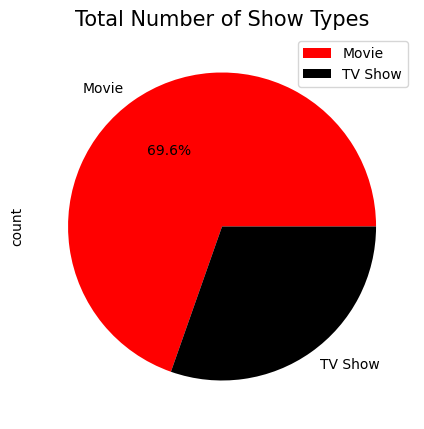

In [127]:
# Assuming 'df' is your DataFrame and 'type' is a column in it
# Count the number of occurrences of each show type
shows = df['type'].value_counts()

# Specify colors for the pie chart slices
colors = ['red', 'black']

# Create a pie chart of the show types
shows.plot.pie(figsize=(5, 5), autopct='%1.1f%%', fontsize=10, colors=colors)

# Add a title and legend to the chart
plt.title('Total Number of Show Types', fontsize=15, fontfamily='sans-serif')
plt.legend(loc='upper right')

# Display the plot
plt.show()


The pie chart visualization shows that approximately 70% of the content on Netflix consists of film, while the remaining 30% are TV shows. Next, to identify the top 10 countries where Netflix is popular, we can use the following code:

## Movies & TV Shows added over time

In [128]:
#new df content by type
df_movies = df.loc[df["type"]=="Movie"]
df_tv_shows = df.loc[df["type"]=="TV Show"]

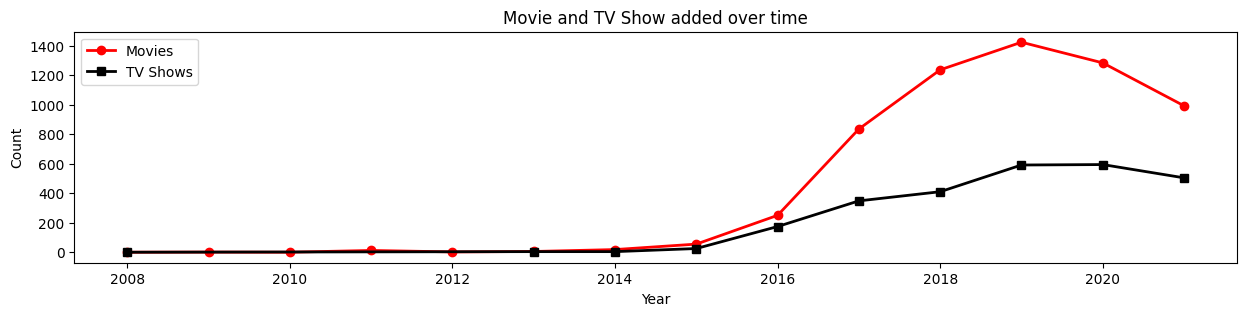

In [129]:
movies_count = df_movies['year_added'].value_counts().sort_index()
tv_shows_count = df_tv_shows['year_added'].value_counts().sort_index()

# Create a line chart to visualize the trends over time
plt.figure(figsize=(15, 3))
plt.plot(movies_count.index, movies_count.values, color='red',
label='Movies',linewidth=2, marker='o')
plt.plot(tv_shows_count.index, tv_shows_count.values, color='k',
label='TV Shows', linewidth=2, marker='s')



# Customize the plot
plt.title('Movie and TV Show added over time')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend()


# Show the plot
plt.show()

The line chart illustrates the number of movies and TV shows added to Netflix over time. It visually represents the growth and trends in content additions, with separate lines for films and TV shows.

Netflix saw its real growth starting from the year 2015, & we can see it added more Movies than TV Shows over the years.

Also, it is interesting that the content addition dropped in 2020. This could be due to the pandemic situation.

Next, we explore the distribution of content additions across different months. This analysis helps us identify patterns and understand when Netflix introduces new content.

###  Number of Movie and TV shows released each year

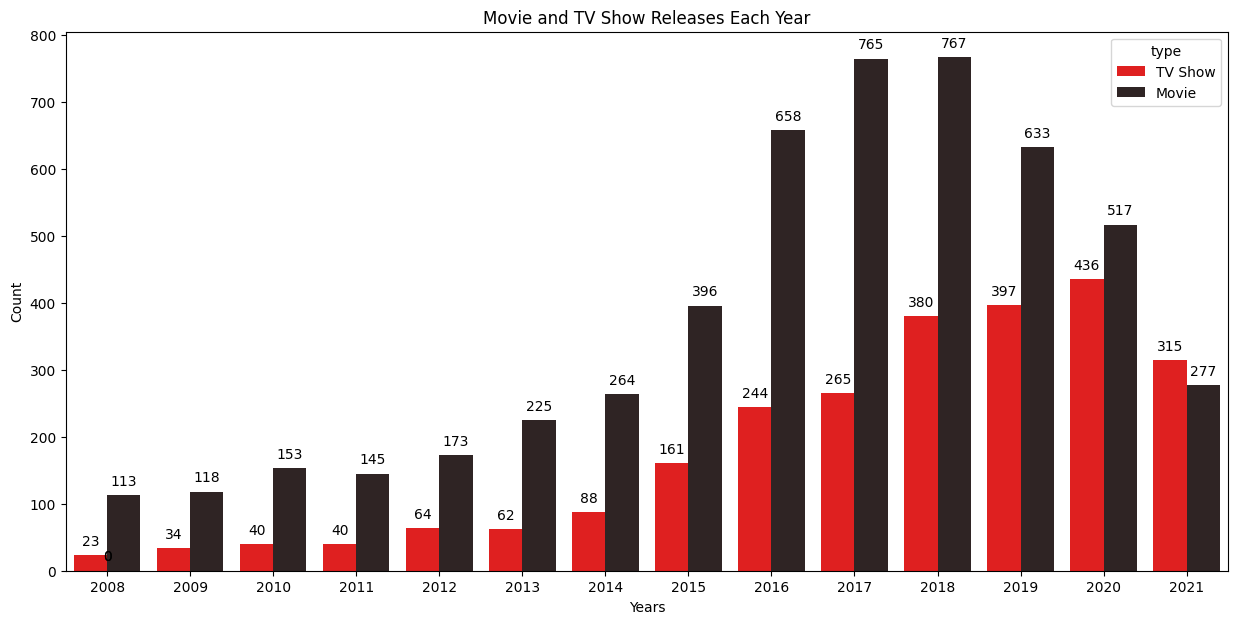

In [130]:
order = range(2008, 2022)

plt.figure(figsize=(15, 7))

ax = sns.countplot(x='release_year', data=df, hue='type', order=order, palette="dark:red_r")

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Movie and TV Show Releases Each Year')
plt.xlabel('Years')
plt.ylabel('Count')

plt.show()


Every year, Netflix updates new content on its platform

## Content structure by Ratings

In [131]:
release_recent_year = df_movies[df_movies['release_year'].between(2008, 2021)]


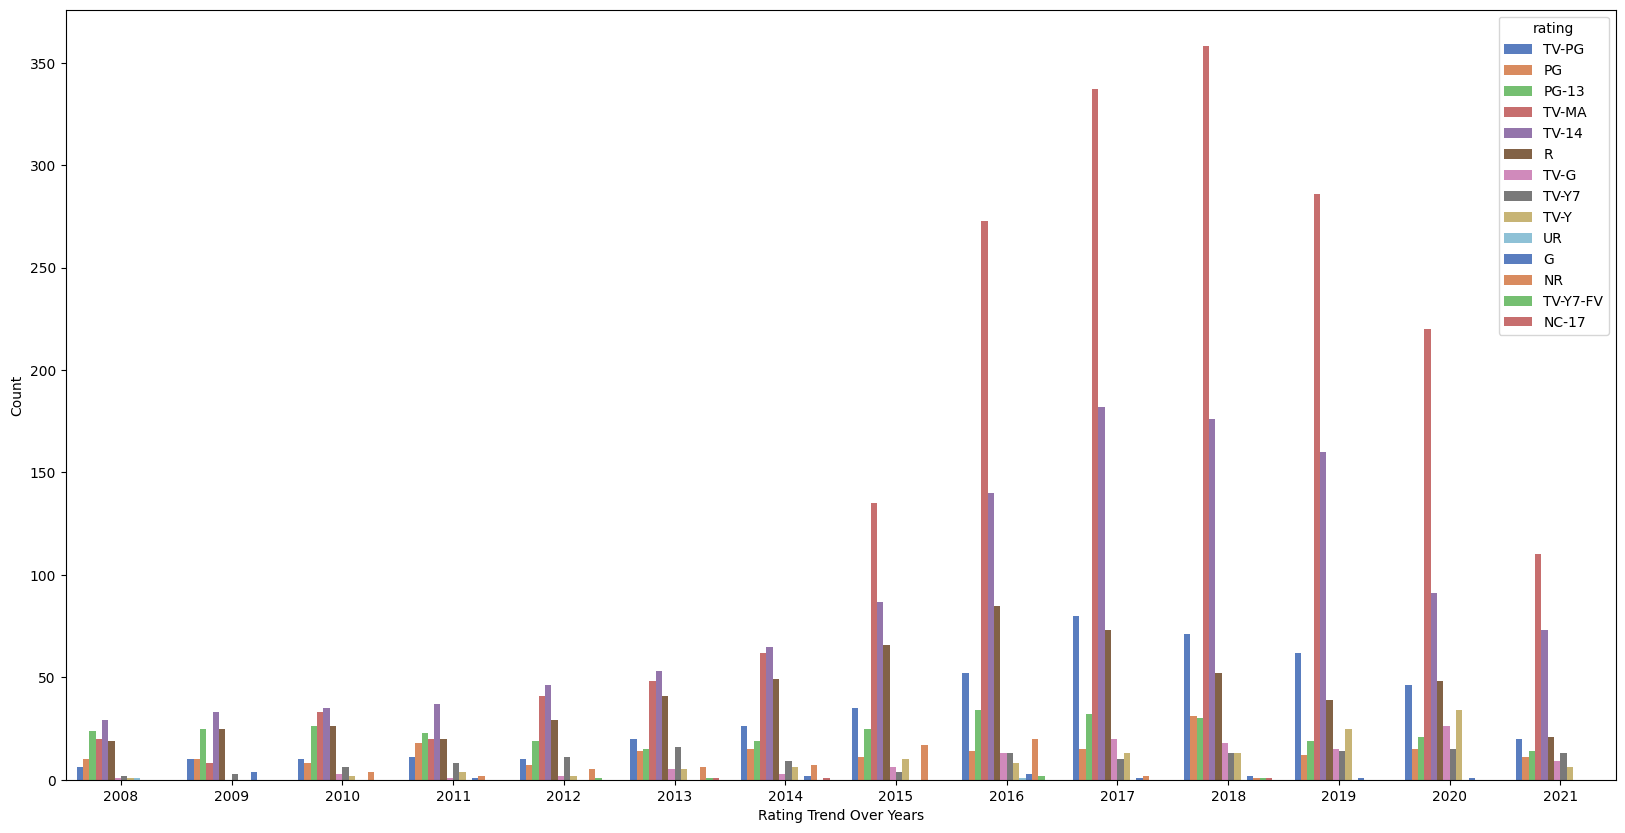

In [132]:

plt.figure(figsize=(20, 10))
sns.countplot(data=release_recent_year, x='release_year', hue='rating',palette='muted')

#setting chart
plt.xlabel('Rating Trend Over Years')
plt.ylabel('Count')


plt.show()


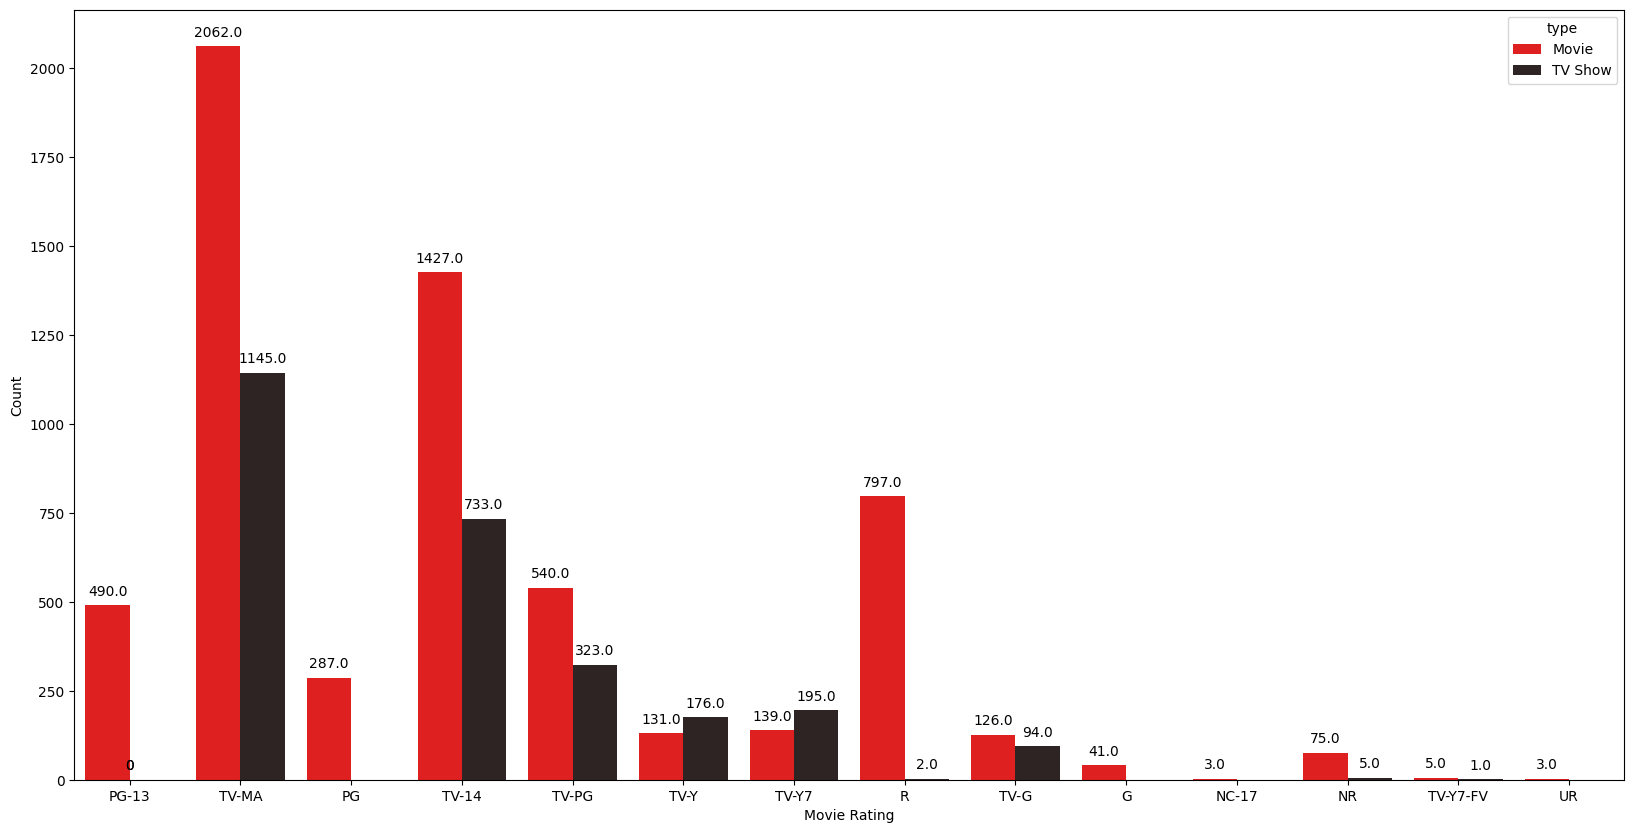

In [133]:
# Assuming df is your DataFrame and 'rating' is a categorical column
rating_counts = df['rating'].value_counts()

plt.figure(figsize=(20, 10))
ax = sns.countplot(data=df, x='rating', palette="dark:red_r", hue='type')

plt.xlabel('Movie Rating')
plt.ylabel('Count')

# Add count numbers above the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()


people prefer Movies over TV Shows on Netflix. Large number of people watch TV-MA rating Movies which are for mature audience

## Content structure by time
- Month
- Day of Month
- Day Of Week

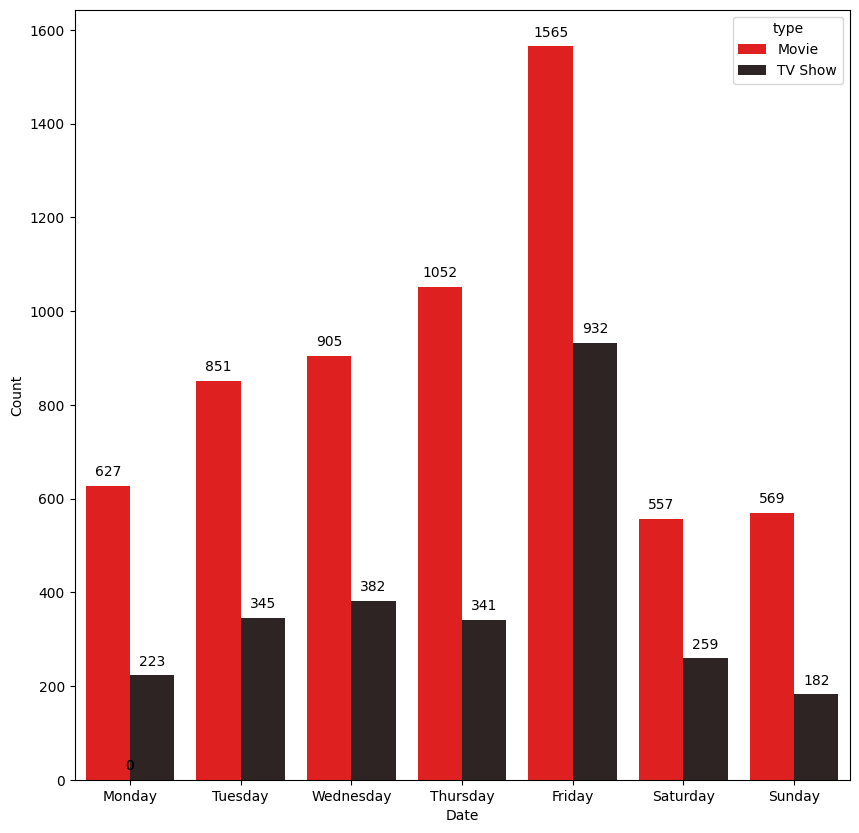

In [134]:
day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

daily_counts = df.groupby(['date_of_week', 'type']).size().reset_index().rename(columns={0: 'num'}) # order X
df['date_of_week'].value_counts().loc[day_order]

# Determine the maximum count
max_day_count = daily_counts.max()


plt.figure(figsize=(10, 10))
ax = sns.barplot(data=daily_counts, x='date_of_week', y='num', palette="dark:red_r",order = day_order, hue='type')
#plt.title('Most content added per date')
plt.xlabel('Date')
plt.ylabel('Count')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

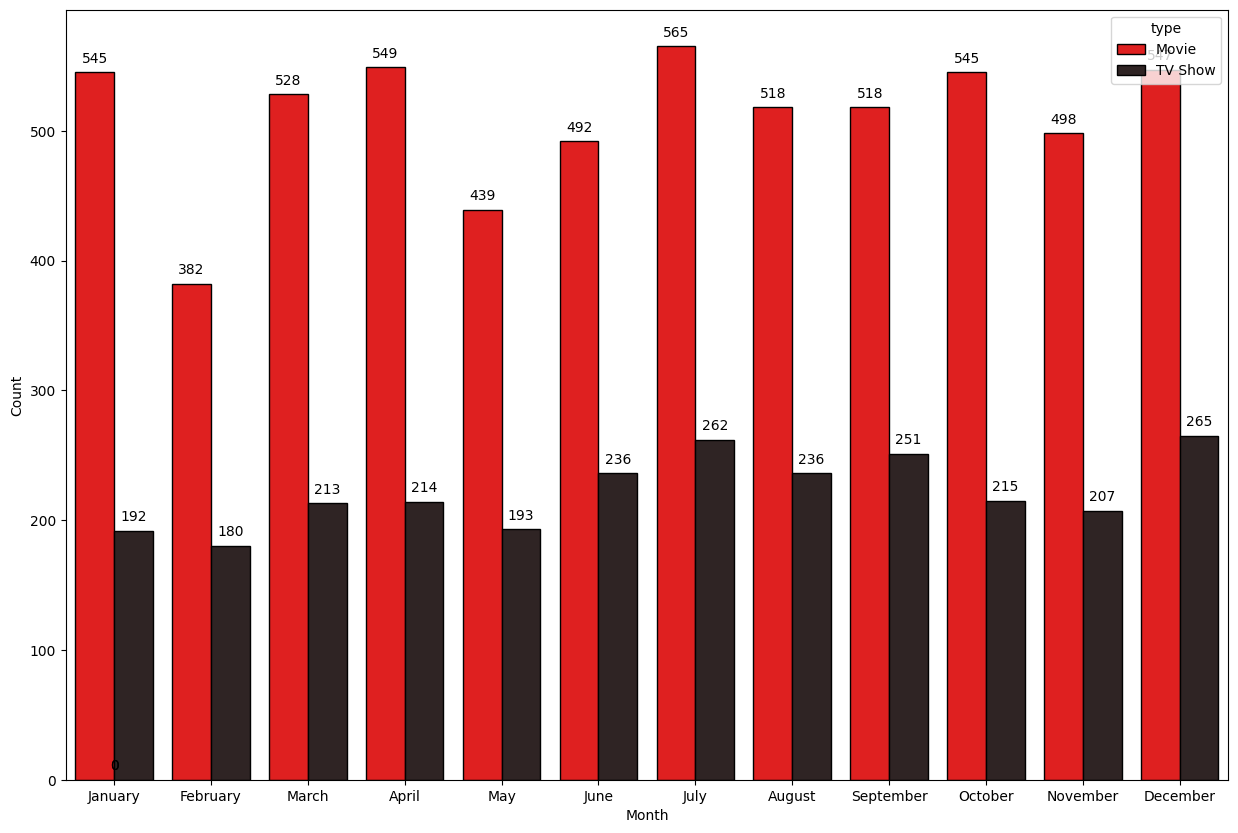

In [135]:
df['month_added'] = pd.to_datetime(df['date_added']).dt.month_name()
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July','August', 'September', 'October', 'November', 'December']
monthly_counts = df.groupby(['month_added', 'type']).size().reset_index().rename(columns={0: 'num'})# order X
df['month_added'].value_counts().loc[month_order]
max_month_count = monthly_counts.max()





plt.figure(figsize=(15, 10))
ax = sns.barplot(data = monthly_counts,x='month_added', y='num',palette="dark:red_r", order = month_order,edgecolor='black',hue='type')
#plt.title('Most content added per month')
plt.xlabel('Month')
plt.ylabel('Count')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')


plt.show()

Ending and starting of the year December and January is the best month to release content. The best 4 months to release content are October,  November, December, and January.

## Content structure by  genres

In [136]:
# Use .loc to explicitly set the values in the original DataFrame
df_movies.loc[:, 'genre'] = df_movies['listed_in'].apply(lambda x: x.split(",")[0])
df_tv_shows.loc[:, 'genre'] = df_tv_shows['listed_in'].apply(lambda x: x.split(",")[0])


C:\Users\trime\AppData\Local\Temp\ipykernel_21752\3898751785.py:8: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



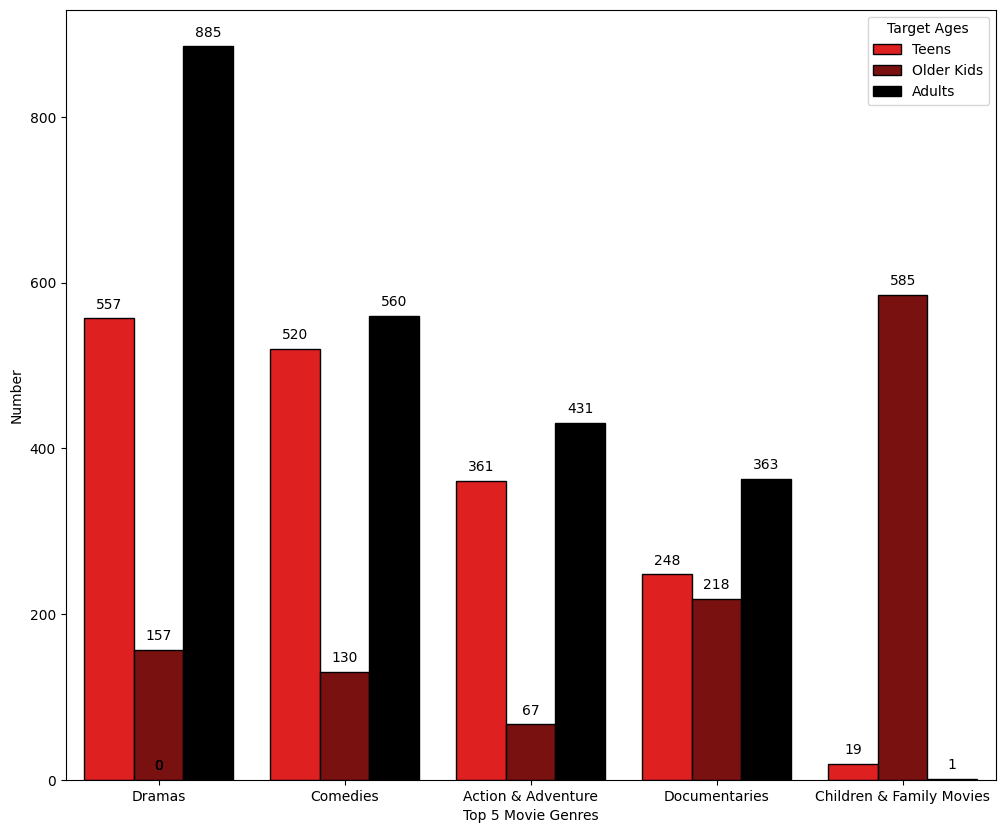

In [137]:
plt.figure(figsize=(12, 10))

# Create the count plot
ax = sns.countplot(x='genre', hue='target_ages', data=df_movies, order=df_movies["genre"].value_counts().index[0:5],
                   palette=['red', 'darkred', 'black'], edgecolor='black')

# Rotate x-axis labels
ax.set_xticklabels(ax.get_xticklabels(),ha='center')

# Add count numbers above the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.xlabel('Top 5 Movie Genres')
plt.ylabel('Number')
#plt.title('Distribution of Top 5 Movie Genres by Target Ages')
plt.legend(title='Target Ages')

plt.show()


C:\Users\trime\AppData\Local\Temp\ipykernel_21752\2228317029.py:8: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



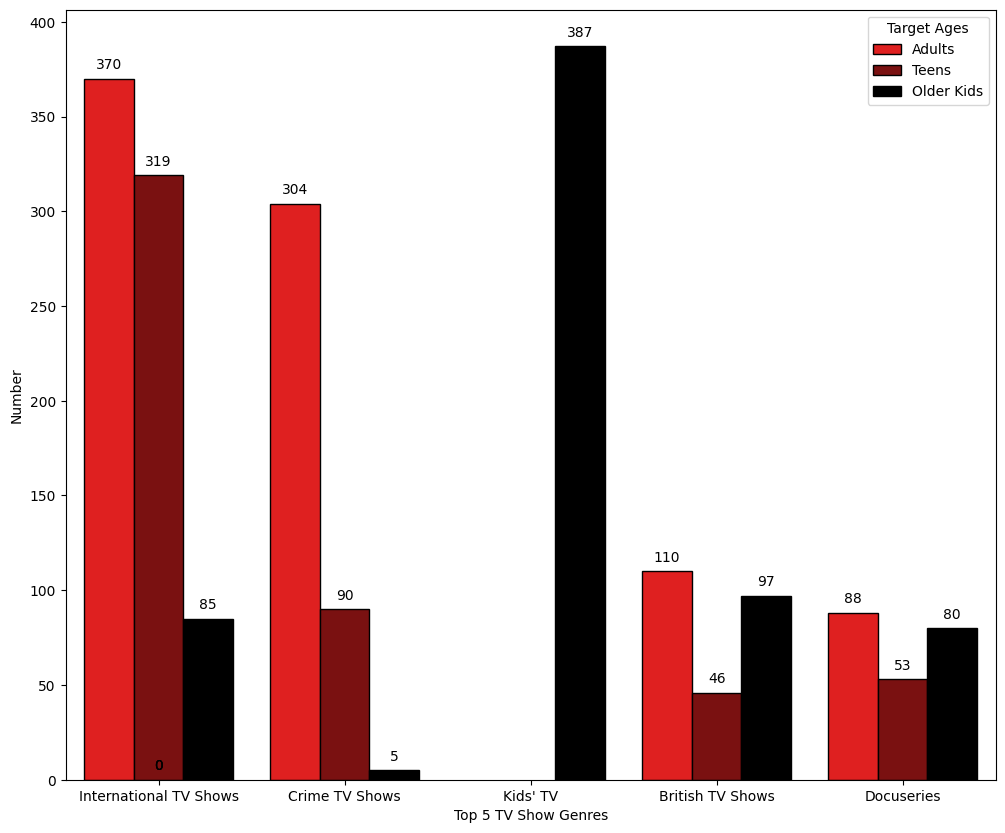

In [138]:
plt.figure(figsize=(12, 10))

# Create the count plot
ax = sns.countplot(x='genre', hue='target_ages', data=df_tv_shows, order=df_tv_shows["genre"].value_counts().index[0:5],
                   palette=['red', 'darkred', 'black'], edgecolor='black')

# Rotate x-axis labels
ax.set_xticklabels(ax.get_xticklabels(),ha='center')

# Add count numbers above the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.xlabel('Top 5 TV Show Genres')
plt.ylabel('Number')
#plt.title('Distribution of Top 5 TV Show Genres by Target Ages')
plt.legend(title='Target Ages')

plt.show()


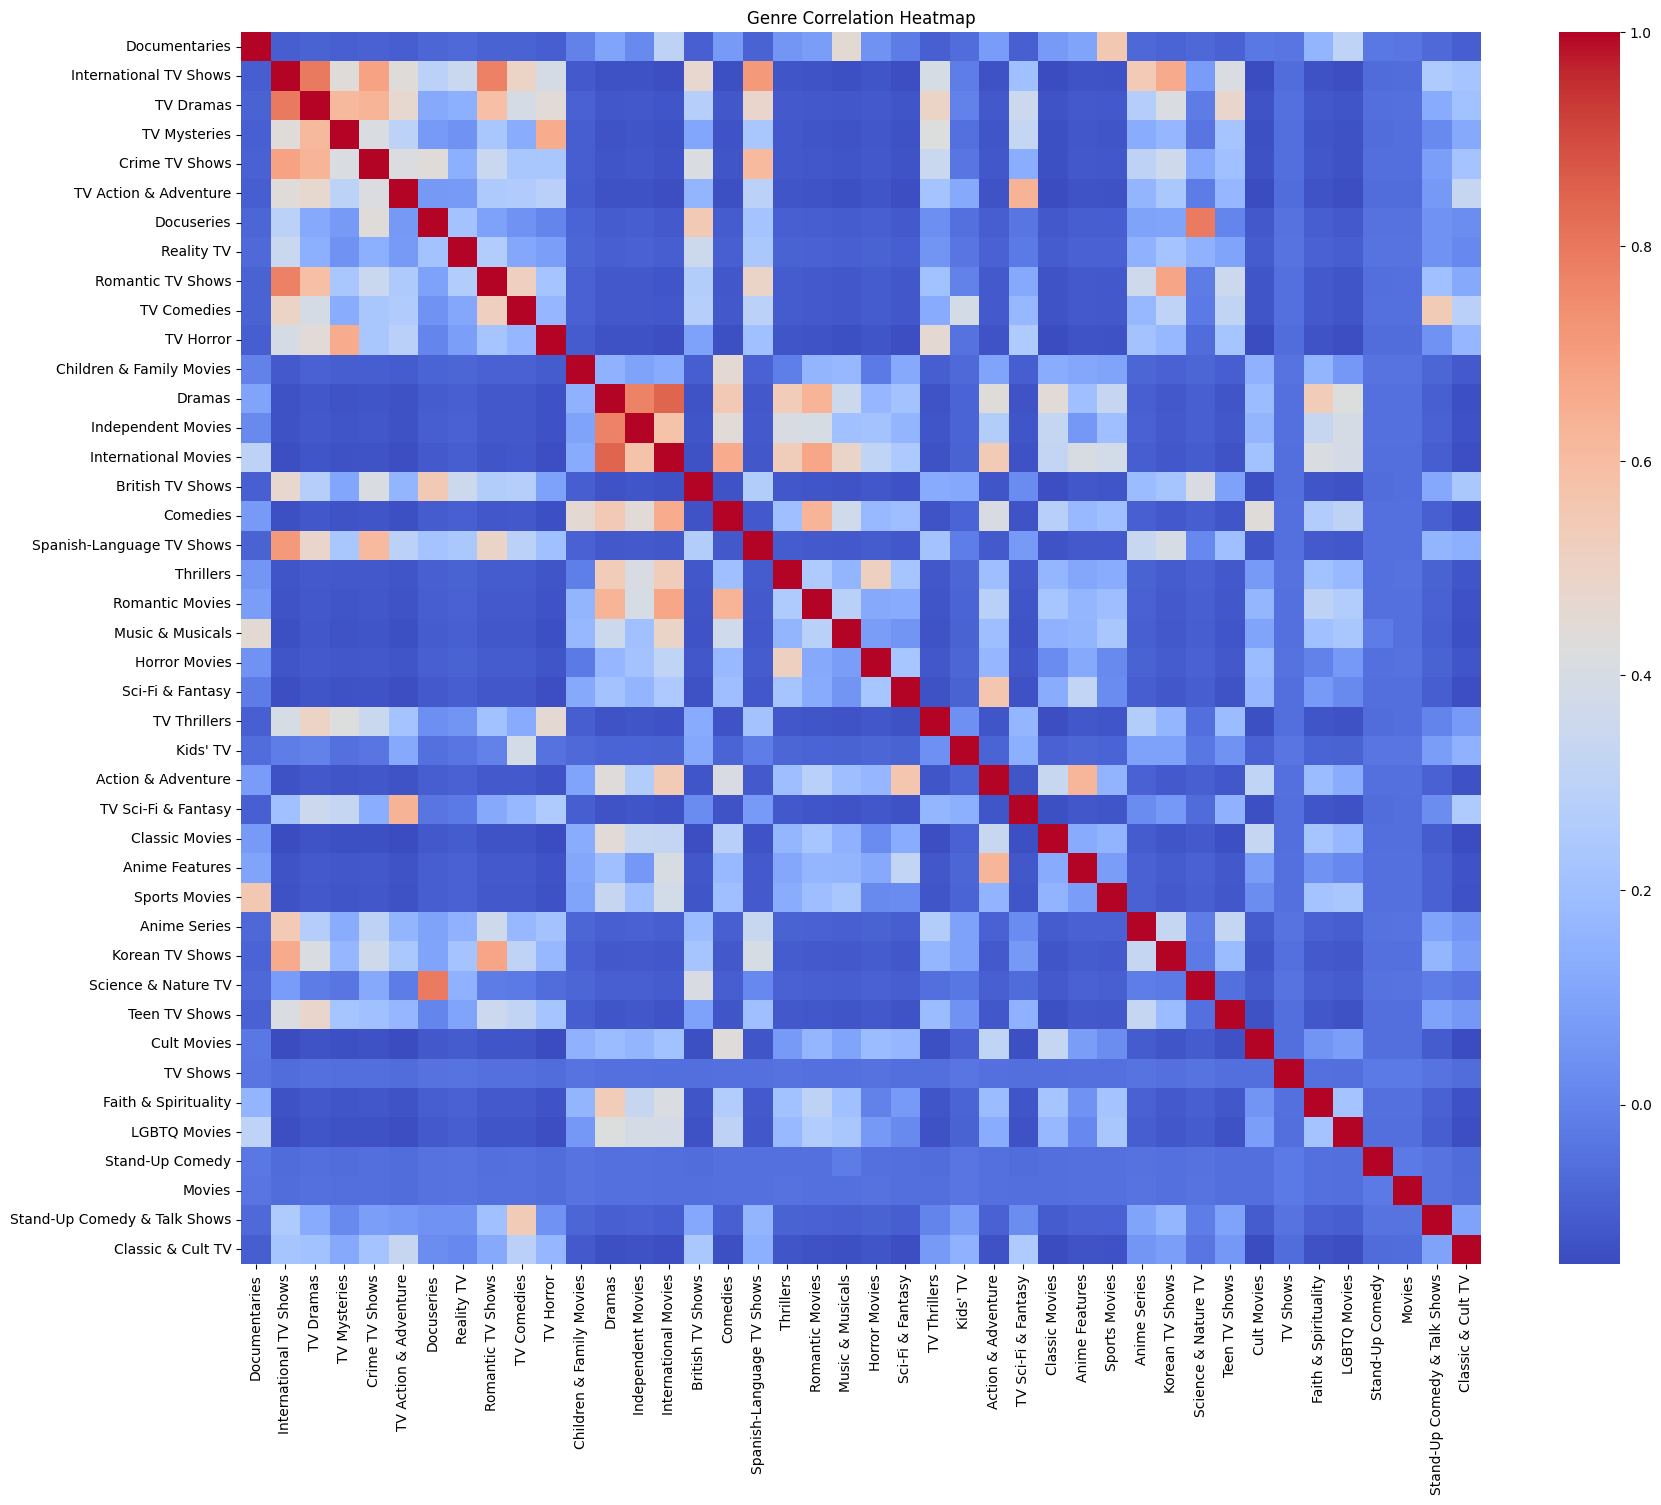

In [139]:
# Extracting unique genres from the 'listed_in' column
genres = df['listed_in'].str.split(', ', expand=True).stack().unique()

# Create a new DataFrame to store the genre data
genre_data = pd.DataFrame(index=genres, columns=genres, dtype=float)

# Fill the genre data DataFrame with zeros
genre_data.fillna(0, inplace=True)

# Iterate over each row in the original DataFrame and update the genre data DataFrame
for _, row in df.iterrows():
    listed_in = row['listed_in'].split(', ')
    for genre1 in listed_in:
        for genre2 in listed_in:
            genre_data.at[genre1, genre2] += 1

# Create a correlation matrix using the genre data
correlation_matrix = genre_data.corr()

# Create the heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')

# Customize the plot
plt.title('Genre Correlation Heatmap')
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Show the plot
plt.show()

Drama is the highest preferred show by the audience then comes the comedy show and action show, the least preferred show is of LGBTQ movies.

https://help.netflix.com/en/node/2064
- Consider to combine Kids and Older Kids into a single one
- Comment: suggested genres for each customer types
- Most films are movies

## Content structure by durations

In [140]:
temp_duration = df_movies['duration'].apply(lambda x: int(x.split(' ')[0]) if ('min' in str(x)) else x)
temp_duration

0        90
6        91
7       125
9       104
12      127
       ... 
8801     96
8802    158
8804     88
8805     88
8806    111
Name: duration, Length: 6126, dtype: int64

In [141]:
# Split into 30min step, upto 3 hours, 3h+
df_movies.loc[temp_duration.loc[temp_duration < 30].index, 'duration_bin'] = 'Less than 30 min'
df_movies.loc[temp_duration.loc[(temp_duration >= 30)&(temp_duration <60 )].index, 'duration_bin'] = 'More than 30 min - 1 hours'
df_movies.loc[temp_duration.loc[(temp_duration >=60)&(temp_duration<90)].index, 'duration_bin'] = 'More than 1 hours - 1.30 hours'
df_movies.loc[temp_duration.loc[(temp_duration >=90)& (temp_duration < 120)].index,'duration_bin'] = 'More than 1.30 - 2 hours'
df_movies.loc[temp_duration.loc[(temp_duration >=120)&(temp_duration <150)].index, 'duration_bin'] = '2 - 2.30 hours'
df_movies.loc[temp_duration.loc[temp_duration >= 150].index, 'duration_bin'] = 'More than 2.30 hours'

C:\Users\trime\AppData\Local\Temp\ipykernel_21752\2962657034.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [142]:
duration_movies_counts = df_movies['duration_bin'].value_counts(ascending=False)
max_duration = duration_movies_counts.max()

C:\Users\trime\AppData\Local\Temp\ipykernel_21752\1678449364.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




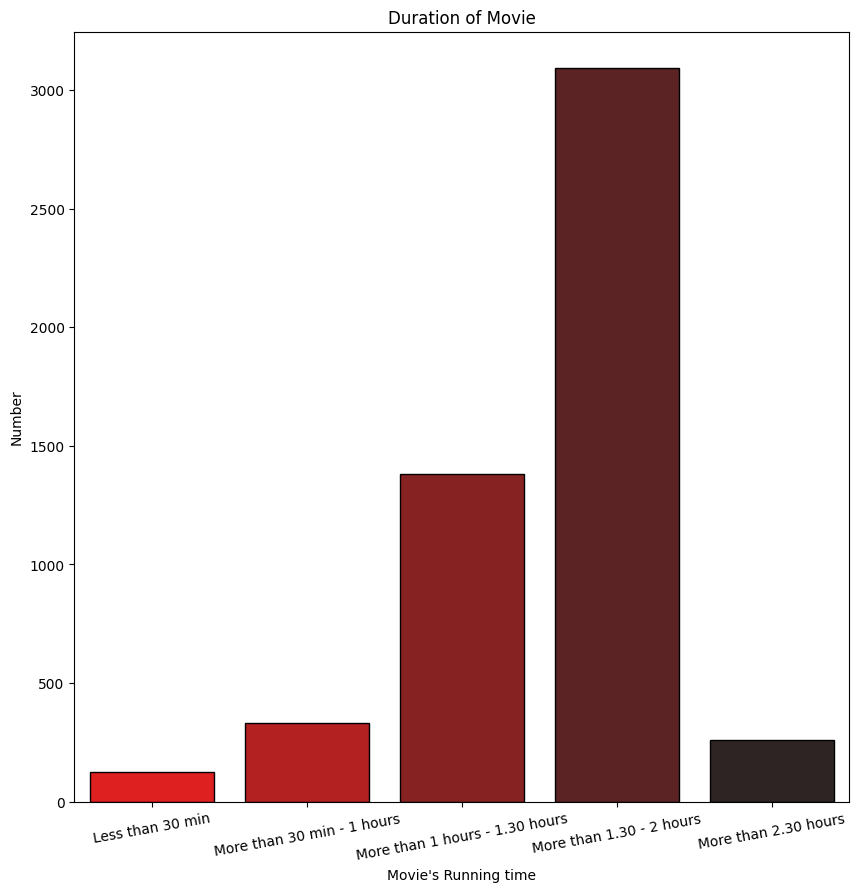

In [143]:
plt.figure(figsize=(10,10))
sns.countplot(data = df_movies,x='duration_bin',
                                          order = ['Less than 30 min','More than 30 min - 1 hours','More than 1 hours - 1.30 hours','More than 1.30 - 2 hours','More than 2.30 hours'],
                                          palette="dark:red_r",edgecolor='black')
plt.xlabel("Movie's Running time")
plt.ylabel("Number")
plt.xticks(rotation = 10)
plt.title('Duration of Movie')

#for index, value in enumerate(duration_movies_counts.values):
#    countplot_movies_duration.text(index, value, str(value), ha='center', va='bottom')
plt.show()

In [144]:
temp_duration_tvshow = df_tv_shows['duration'].apply(lambda x: int(x.split(' ')[0]) if ('Season' in str(x)) else x)


In [145]:

df_tv_shows.loc[temp_duration_tvshow.loc[temp_duration_tvshow == 1].index, 'duration_bin'] = '1 Season'
df_tv_shows.loc[temp_duration_tvshow.loc[temp_duration_tvshow == 2].index, 'duration_bin'] = '2 Seasons'
df_tv_shows.loc[temp_duration_tvshow.loc[temp_duration_tvshow == 3].index, 'duration_bin'] = '3 Seasons'
df_tv_shows.loc[temp_duration_tvshow.loc[temp_duration_tvshow == 4].index, 'duration_bin'] = '4 Seasons'
df_tv_shows.loc[temp_duration_tvshow.loc[temp_duration_tvshow == 5].index, 'duration_bin'] = '5 Seasons'
df_tv_shows.loc[temp_duration_tvshow.loc[temp_duration_tvshow == 6].index, 'duration_bin'] = '6 Seasons'
df_tv_shows.loc[temp_duration_tvshow.loc[temp_duration_tvshow == 7].index, 'duration_bin'] = '7 Seasons'
df_tv_shows.loc[temp_duration_tvshow.loc[temp_duration_tvshow == 8].index, 'duration_bin'] = '8 Seasons'
df_tv_shows.loc[temp_duration_tvshow.loc[temp_duration_tvshow >= 9].index, 'duration_bin'] = '9 Seasons +'

C:\Users\trime\AppData\Local\Temp\ipykernel_21752\4223112484.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [146]:
# Suggest preprocessing here to extract number of seasons + combine >9 seasons
duration_tvshows_counts = df_tv_shows['duration_bin'].value_counts()
max_duration_tv = duration_tvshows_counts.max()

C:\Users\trime\AppData\Local\Temp\ipykernel_21752\4003431086.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




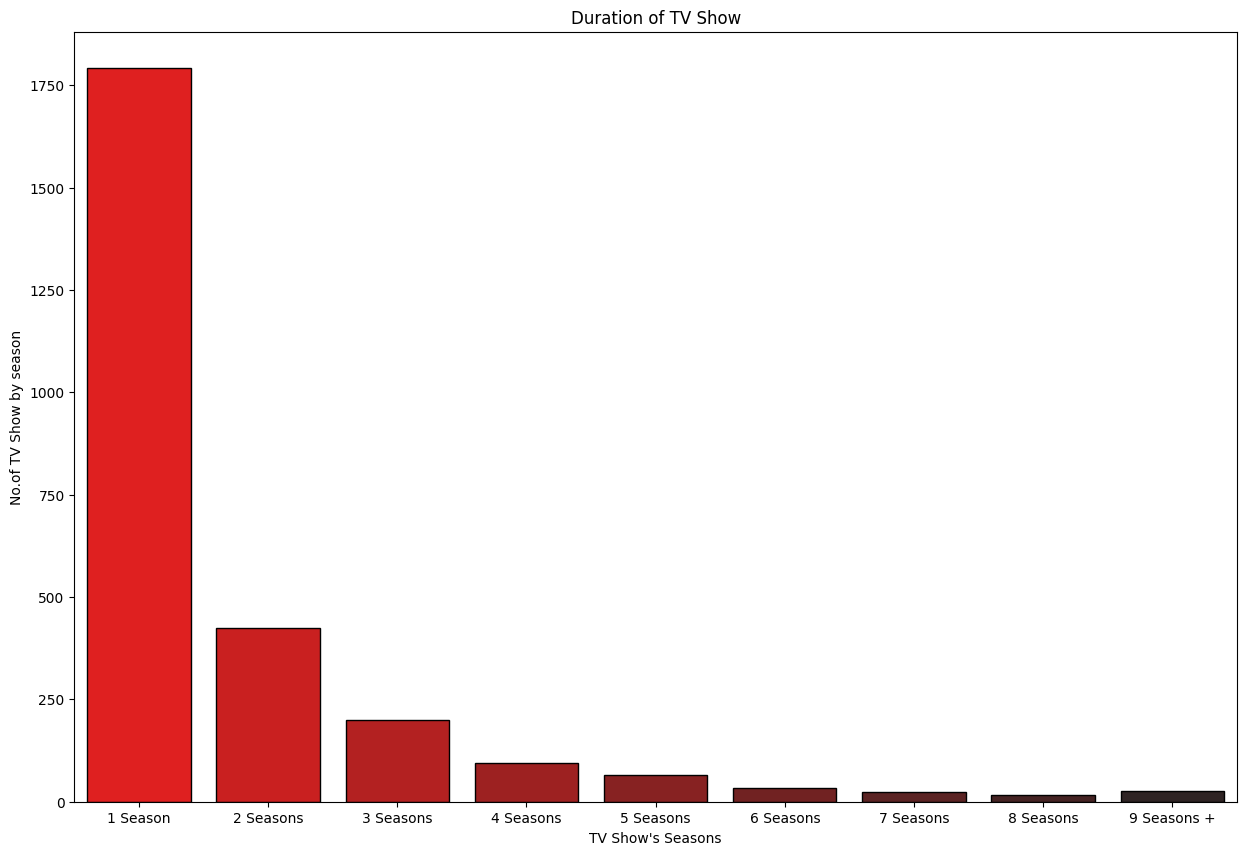

In [147]:
plt.figure(figsize=(15,10))
countplot_tvshows_duration=sns.countplot(data = df_tv_shows,
                                         x='duration_bin',
                                         order = ['1 Season','2 Seasons','3 Seasons','4 Seasons','5 Seasons','6 Seasons','7 Seasons','8 Seasons','9 Seasons +'],
                                         palette="dark:red_r",
                                         edgecolor='black')
plt.title('Duration of TV Show')
plt.xlabel("TV Show's Seasons")
plt.ylabel("No.of TV Show by season")
#plt.xticks(rotation=20)
#for index, value in enumerate(duration_tvshows_counts.values):
#    countplot_tvshows_duration.text(index, value, str(value), ha='center', va='bottom')

plt.show()

## title and description

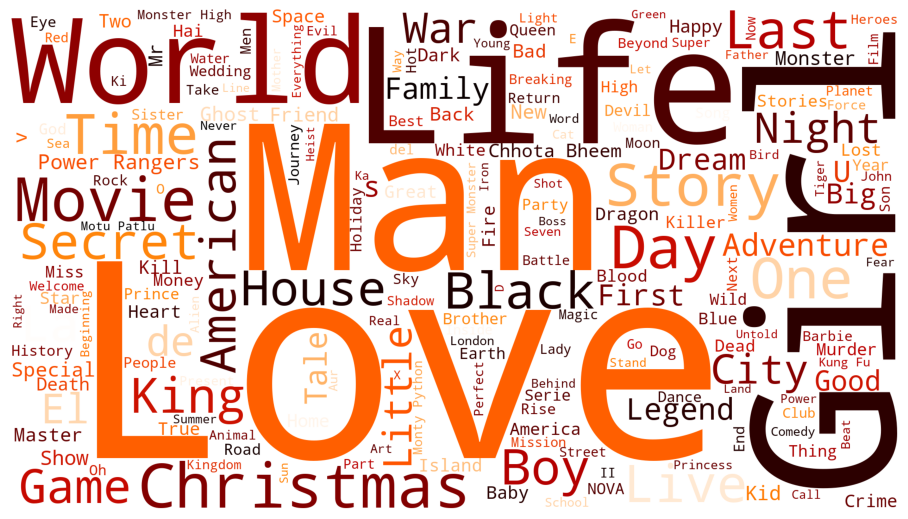

In [148]:
stopwords = set(STOPWORDS)


plt.subplots(figsize=(20,5))
wordcloud = WordCloud(
                          background_color='white',
                          stopwords = stopwords,
                          width=1920,
                          height=1080,
                          colormap = 'gist_heat'
                         ).generate(" ".join(df.title))

plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()



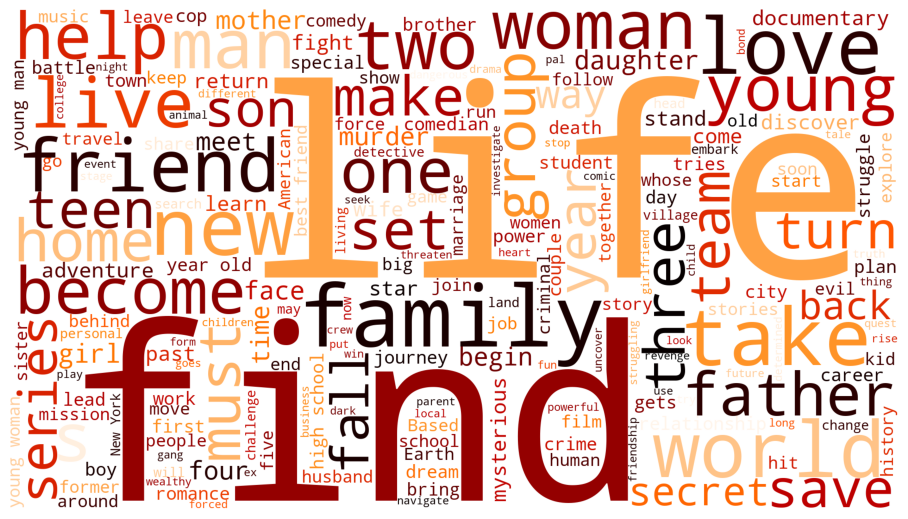

In [149]:
stopwords = set(STOPWORDS)


plt.subplots(figsize=(20,5))
wordcloud = WordCloud(
                          background_color='white',
                          stopwords = stopwords,
                          width=1920,
                          height=1080,
                          colormap = 'gist_heat'
                         ).generate(" ".join(df.description))

plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.tight_layout(pad = 0)

plt.show()

## Content structure by country

In [150]:
from collections import Counter

In [151]:
from plotly.subplots import make_subplots

In [152]:
country_order = df['country_single'].value_counts()[:10].index
countryVScontent = df[['type', 'country_single']].groupby('country_single')['type'].value_counts().unstack().loc[country_order].reset_index()
countryVScontent

type,country_single,Movie,TV Show
0,United States,2800.0,1238.0
1,India,927.0,81.0
2,United Kingdom,382.0,246.0
3,Canada,187.0,84.0
4,Japan,85.0,173.0
5,France,148.0,64.0
6,South Korea,47.0,164.0
7,Spain,129.0,52.0
8,Mexico,86.0,48.0
9,Australia,61.0,55.0


In [153]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=countryVScontent['country_single'],
    y=countryVScontent['Movie'],
    name='Movie',

    marker=dict(
        color='rgba(238, 25, 18, 1)'
    )
))

fig.add_trace(go.Bar(
    x=countryVScontent['country_single'],
    y=countryVScontent['TV Show'],
    name='TV Show',

    marker=dict(
        color='rgba(40, 34, 34, 1)'
    )
))


fig.update_layout(
    title={
        'text': 'Top 5 countries provide content on Netflix',
        'y': 0.9,
        'x': 0.5,
        'font_size': 25,

        'xanchor': 'center',
        'yanchor': 'top'
    },
    barmode='group', 
    height=650,
    width=1550,
    plot_bgcolor='white',  # Set background color of the plot
    paper_bgcolor='white'  # Set background color of the paper (area outside the plot)
)

fig.show()


In [154]:
country_order = df['country_single'].value_counts()[:10].index
countryVStarget_ages = df[['target_ages', 'country_single']].groupby('country_single')['target_ages'].value_counts().unstack().loc[country_order].reset_index()
countryVStarget_ages

target_ages,country_single,Adults,Older Kids,Teens
0,United States,1847.0,1152.0,1039.0
1,India,266.0,174.0,568.0
2,United Kingdom,329.0,162.0,137.0
3,Canada,129.0,97.0,45.0
4,Japan,91.0,69.0,98.0
5,France,132.0,40.0,40.0
6,South Korea,93.0,34.0,84.0
7,Spain,148.0,14.0,19.0
8,Mexico,103.0,15.0,16.0
9,Australia,53.0,45.0,18.0


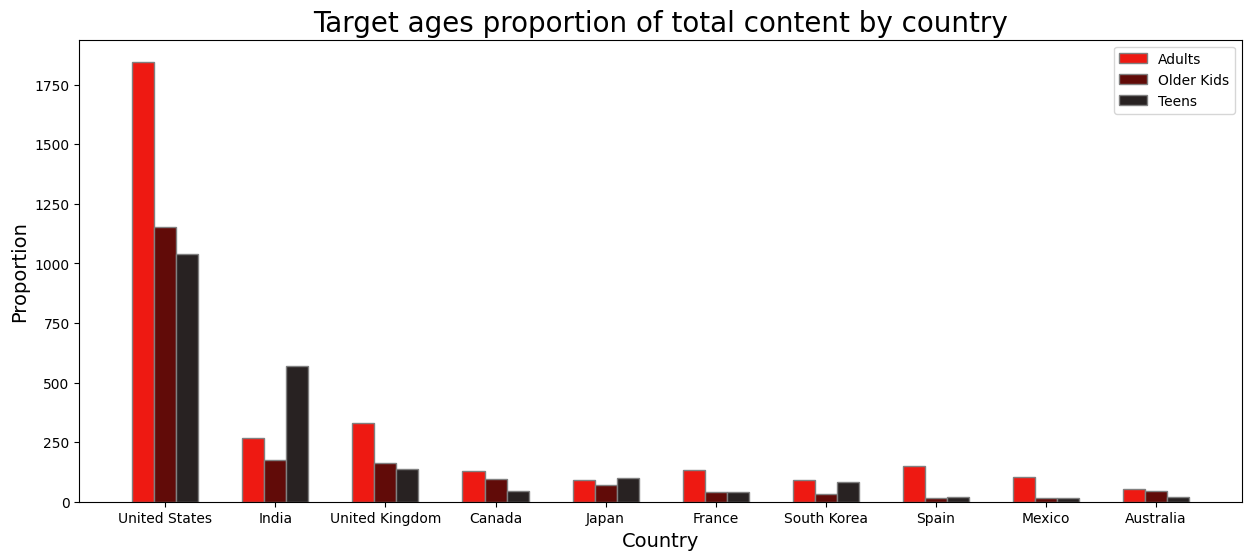

In [155]:
from matplotlib.colors import to_rgba

# Define colors for each category
colors = [
    to_rgba((238/255, 25/255, 18/255, 1)),
    to_rgba((97/255, 11/255, 8/255, 1)),
    to_rgba((40/255, 34/255, 34/255, 1))
]

# Create figure and axis
fig, ax = plt.subplots(figsize=(15, 6))

# Set the width of the bars
bar_width = 0.2

# Set positions for each group of bars
r1 = np.arange(len(countryVStarget_ages['country_single']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plot bars for each category
ax.bar(r1, countryVStarget_ages['Adults'], color=colors[0], width=bar_width, edgecolor='grey', label='Adults')
ax.bar(r2, countryVStarget_ages['Older Kids'], color=colors[1], width=bar_width, edgecolor='grey', label='Older Kids')
ax.bar(r3, countryVStarget_ages['Teens'], color=colors[2], width=bar_width, edgecolor='grey', label='Teens')

# Set x-axis labels and tick locations
ax.set_xticks([r + bar_width for r in range(len(countryVStarget_ages['country_single']))])
ax.set_xticklabels(countryVStarget_ages['country_single'])

# Set plot title and labels
plt.title('Target ages proportion of total content by country', fontsize=20)
plt.xlabel('Country', fontsize=14)
plt.ylabel('Proportion', fontsize=14)

# Add legend
plt.legend()

# Show the plot
plt.show()


## Most add genres in recent years


In [156]:
from collections import Counter

In [157]:
# Create subset of data with required columns.
recent_years = pd.DataFrame(df.groupby(['year_added', 'listed_in'])['listed_in'].count())
recent_years.rename(columns={'listed_in':'Count'}, inplace=True)
recent_years = recent_years.reset_index()
recent_years.drop(recent_years[recent_years.year_added < 2018].index, inplace=True)

def seperate_all_genre(year):
  year_added = recent_years[recent_years['year_added'] == year]
  year_added = ", ".join(year_added['listed_in'].dropna()).split(", ")
  year_added_dict = dict(Counter(year_added))
  return year_added_dict
# Create a list of years.
year_list = [2018,2019,2020,2021]
# Iterate through all values in yr_list.
year_genre_count_list = {}
for i in year_list:
  data = seperate_all_genre(i)
  year_genre_count_list[i] = data
  year_genre_count_df = pd.DataFrame(year_genre_count_list).reset_index()
  year_genre_count_df.rename({'index':'Genre'}, inplace=True, axis=1)

In [158]:
df_1 = year_genre_count_df.sort_values([2018, 2019, 2020, 2021], ascending=False)

fig = go.Figure()

fig.add_trace(go.Scatter(
    y=df_1[2018],
    x=df_1['Genre'],
    mode='lines+markers',
    name='2018'
))

fig.add_trace(go.Scatter(
    y=df_1[2019],
    x=df_1['Genre'],
    mode='lines+markers',
    name='2019'
))

fig.add_trace(go.Scatter(
    y=df_1[2020],
    x=df_1['Genre'],
    mode='lines+markers',
    name='2020'
))

fig.add_trace(go.Scatter(
    y=df_1[2021],
    x=df_1['Genre'],
    mode='lines+markers',
    name='2021'
))

# Updating layout
fig.update_xaxes(tickangle=45)
fig.update_layout(
    
    barmode='group',  # 'group' for grouped bars, 'overlay' for overlaid bars
    height=650,
    width=1550,
    legend=dict(x=0.38, y=1.1, orientation="h")
)

# Show the figure
fig.show()


## Conclusion
With the help of this article, we have been able to learn about-

1 Quantity: Our analysis revealed that Netflix had added more movies than TV shows, aligning with the expectation that movies dominate their content library.

2 Content Addition: July emerged as the month when Netflix adds the most content, closely followed by December, indicating a strategic approach to content release.

3 Genre Correlation: Strong positive associations were observed between various genres, such as TV dramas and international TV shows, romantic and international TV shows, and independent movies and dramas. These correlations provide insights into viewer preferences and content interconnections.

4 Movie Lengths: The analysis of movie durations indicated a peak around the 1960s, followed by a stabilization around 100 minutes, highlighting a trend in movie lengths over time.

5 TV Show Episodes: Most TV shows on Netflix have one season, suggesting a preference for shorter series among viewers.

6 Common Themes: Words like love, life, family, and adventure were frequently found in titles and descriptions, capturing recurring themes in Netflix content.

7 Rating Distribution: The distribution of ratings over the years offers insights into the evolving content landscape and audience reception.

8 Data-Driven Insights: Our data analysis journey showcased the power of data in unraveling the mysteries of Netflix’s content landscape, providing valuable insights for viewers and content creators.

9 Continued Relevance: As the streaming industry evolves, understanding these patterns and trends becomes increasingly essential for navigating the dynamic landscape of Netflix and its vast library.

10 Happy Streaming: We hope this blog has been an enlightening and entertaining journey into the world of Netflix, and we encourage you to explore the captivating stories within its ever-changing content offerings. Let the data guide your streaming adventures!

# Recommendation System

A recommender system is an application of machine learning that provides recommendations to users on what they might like based on their historical preferences

A content-based recommender learns a profile of the new user’s interests based on the features present, in objects the user has rated. It’s basically a keyword specific recommender system here keywords are used to describe the items. Thus, in a content-based recommender system the algorithms used are such that it recommends similar items that the user has liked in the past or is examining currently.

In [159]:
#new data
features=['genre','director','cast','description','title']
recommendation_df = df[features]

In [160]:
#filters
recommendation_df['director'] = recommendation_df['director'].fillna(recommendation_df['director'].mode()[0])
recommendation_df['cast'] = recommendation_df['cast'].fillna(recommendation_df['cast'].mode()[0])

recommendation_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8800 entries, 0 to 8806
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   genre        8800 non-null   object
 1   director     8800 non-null   object
 2   cast         8800 non-null   object
 3   description  8800 non-null   object
 4   title        8800 non-null   object
dtypes: object(5)
memory usage: 670.5+ KB


C:\Users\trime\AppData\Local\Temp\ipykernel_21752\3557809473.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\trime\AppData\Local\Temp\ipykernel_21752\3557809473.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [161]:
recommendation_df.head()

,genre,director,cast,description,title
0,Documentaries,Kirsten Johnson,David Attenborough,"As her father nears the end of his life, filmm...",Dick Johnson Is Dead
1,International TV Shows,Rajiv Chilaka,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...","After crossing paths at a party, a Cape Town t...",Blood & Water
2,Crime TV Shows,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",To protect his family from a powerful drug lor...,Ganglands
3,Docuseries,Rajiv Chilaka,David Attenborough,"Feuds, flirtations and toilet talk go down amo...",Jailbirds New Orleans
4,International TV Shows,Rajiv Chilaka,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",In a city of coaching centers known to train I...,Kota Factory


In [162]:
#Cleaning the data by making all the words in lower case.
def clean_data(x):
        return str.lower(x.replace(" ", ""))

In [163]:
for feature in features:
    recommendation_df[feature] = recommendation_df[feature].apply(clean_data)

recommendation_df.sample(10)

C:\Users\trime\AppData\Local\Temp\ipykernel_21752\2185211645.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,genre,director,cast,description,title
1072,children&familymovies,suhaskadav,"sauravchakraborty,ganeshdiweker,arpitavora,man...","defeatedbythestrongyetnaivemotuinarace,anevilh...",motupatluinthecityofgold
4957,britishtvshows,rajivchilaka,"surannejones,bertiecarvel,clare-hopeashitey,ch...","whenshesuspectsherhusbandischeatingonher,dr.ge...",doctorfoster
5417,dramas,justinkelly,"jamesfranco,zacharyquinto,emmaroberts,charliec...",gayactivistmichaelglatzebeginsapainfuljourneyw...,iammichael
5943,dramas,robertmarkowitz,"danielj.travanti,jobethwilliams,richardmasur,m...","aftertheirchildwasabductedandmurdered,johnandr...",adam:hissongcontinues
1818,dramas,philippearactingi,"rodneyelhaddad,nadinelabaky,nadaaboufarhat,lil...","after15yearsinfrance,kamalreturnstohisnativebe...",bosta
731,internationaltvshows,rajivchilaka,"sunghoon,leetae-gon,parkjoo-mi,leega-ryoung,le...",everythingcomesunravelingforthreesuccessfulwom...,love(ft.marriageanddivorce)
1404,kids'tv,rajivchilaka,"jacenorman,cooperbarnes,rieledowns,seanryanfox...",anewpart-timejobforceshenryharttobalancetwoliv...,henrydanger
5205,tvdramas,rajivchilaka,"morganspector,alyssasutherland,gusbirney,danic...","trappedbyamysteriousfog,residentsofamainevilla...",themist
802,action&adventure,jamesmcteigue,"rain,naomieharris,benmiles,rickyune,shôkosugi,...",aformerassassinmustprotecthimselfandaeuropolag...,ninjaassassin
3352,internationaltvshows,rajivchilaka,"ludwigsimon,luisebefort,michellebarthel,mohame...",amysteriousclassmateleadsfouridealisticteensin...,wearethewave


In [164]:
def overall_info(x):
    return x['director'] + ' ' + x['cast'] + ' ' +x['genre']+' '+ x['description']

In [165]:
recommendation_df['overall_info'] = recommendation_df.apply(overall_info, axis=1)

C:\Users\trime\AppData\Local\Temp\ipykernel_21752\1962853730.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Calculating Cosine Similarity scores


In [166]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(recommendation_df['overall_info'])

In [167]:
# Compute the Cosine Similarity matrix based on the count_matrix
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [168]:
# Reset index of our main DataFrame and construct reverse mapping as before
recommendation_df=recommendation_df.reset_index()
indices = pd.Series(recommendation_df.index, index=recommendation_df['title'])

### Defining the recommendation system¶


In [169]:
def get_recommendations_new(title, cosine_sim):
    title=title.replace(' ','').lower()
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df['title'].iloc[movie_indices]

### Getting Recommendations¶


In [170]:
get_recommendations_new('Extraction', cosine_sim2)

7403                                            Marauders
6759                                           First Kill
8464                                           The Prince
8268                                     The Darkest Dawn
354                                    The Last Boy Scout
2713                                          Sol Levante
4170                                                Polar
6077                                            Abdo Mota
6429                                      Casino Tycoon 2
7290    LEGO Ninjago: Masters of Spinjitzu: Day of the...
Name: title, dtype: object

In [171]:
get_recommendations_new('Stranger Things', cosine_sim2)

5200                  Beyond Stranger Things
1127                        Prank Encounters
3624                            No Good Nick
6917                                Hannibal
125                                  Q-Force
1361                          The Unsettling
3654    The Epic Tales of Captain Underpants
6953                                   Helix
14           Crime Stories: India Detectives
368                                 Khawatir
Name: title, dtype: object

In [172]:
get_recommendations_new('Attack on Titan', cosine_sim2)

2062                                  Blue Exorcist
3723                   Magi: The Labyrinth of Magic
7376                      Magi: Adventure of Sinbad
154                             Kuroko's Basketball
1928                                   Black Butler
3088    The Disastrous Life of Saiki K.: Reawakened
3340                                     Maid-Sama!
4063                The Disastrous Life of Saiki K.
4131                              Violet Evergarden
4389                       Beyblade Burst Evolution
Name: title, dtype: object